In [1]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push

!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 37.9 MB/s 
     |████████████████████████████████| 189 kB 46.3 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 561 kB 43.8 MB/s 
     |████████████████████████████████| 51 kB 299 kB/s 
     |████████████████████████████████| 130 kB 48.2 MB/s 


In [5]:
from fastai.vision.all import *

In [6]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


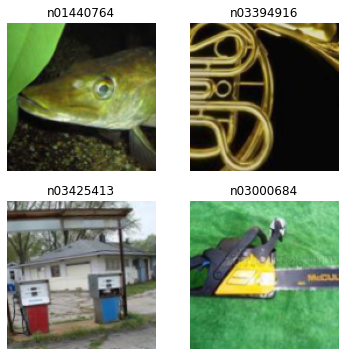

In [7]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

In [8]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c)
    )

SuggestedLRs(valley=0.002511886414140463)

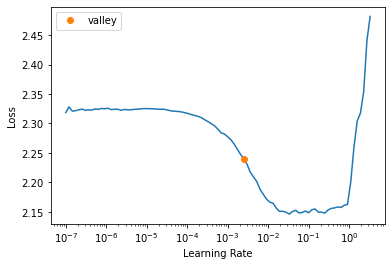

In [9]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(),
                   metrics=accuracy).to_fp16()
learn = get_learner(get_model())
learn.lr_find()

In [10]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.865855,2.642605,0.300637,00:37
1,1.503938,1.357270,0.562548,00:38
2,1.266393,1.146499,0.626497,00:39
3,1.099861,1.119698,0.648662,00:41
4,1.007472,1.016536,0.674904,00:37


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

!git config --global user.email 'intaek428@gmail.com'
!git config --global user.name 'ITHwang'

!git add .
!git commit -m '14.1까지'
!git push